In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/AAPL_stock_prediction_2")

data = pd.read_csv('annual_aapl_data.csv')

data

,Year-Month,start_price,end_price,total_dividends,return
0,1980-12,0.128348,0.117313,0.00,-8.598017
1,1981-01,0.154018,0.097116,0.00,-36.945201
2,1981-02,0.119420,0.091100,0.00,-23.714527
3,1981-03,0.118862,0.084224,0.00,-29.141120
4,1981-04,0.108817,0.097545,0.00,-10.358331
...,...,...,...,...,...
522,2024-06,192.899994,210.145279,0.00,8.940013
523,2024-07,212.089996,221.579468,0.00,4.474266
524,2024-08,224.369995,228.748337,0.25,2.062817
525,2024-09,228.550003,232.743942,0.00,1.835020


In [575]:
data = data[['Year-Month', 'return']]
data

,Year-Month,return
0,1980-12,-8.598017
1,1981-01,-36.945201
2,1981-02,-23.714527
3,1981-03,-29.141120
4,1981-04,-10.358331
...,...,...
522,2024-06,8.940013
523,2024-07,4.474266
524,2024-08,2.062817
525,2024-09,1.835020


In [576]:
device = 'cuda:0' if torch.cuda.is_available() else 'mps'
device

'mps'

/var/folders/8t/zq98g53s2rs8x1qgc3h02m100000gn/T/ipykernel_22093/2340483137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year-Month'] = pd.to_datetime(data['Year-Month'], format='%Y-%m')


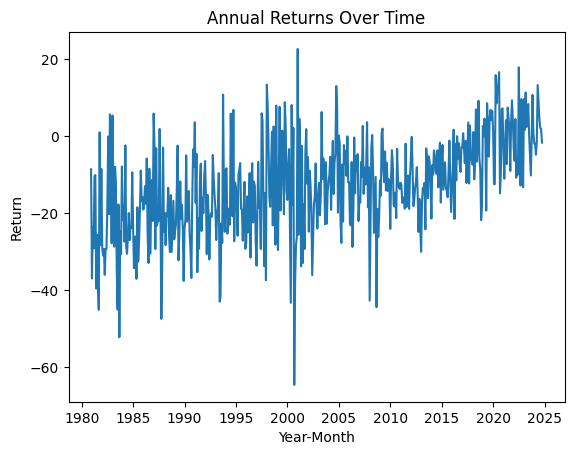

In [577]:
# Transform to a panda date type
data['Year-Month'] = pd.to_datetime(data['Year-Month'], format='%Y-%m')
# Do a graph of the closing value with the date
plt.plot(data['Year-Month'], data['return'])
plt.xlabel('Year-Month')
plt.ylabel('Return')
plt.title('Annual Returns Over Time')
plt.show()

In [578]:
from copy import deepcopy as dc

# Take the dataframes and the number (look back window)
def prepare_dataframe_for_lstm(df, n_steps):
    # Deep copy of the dataframe
    df = dc(df)
    # Set the index to Date
    df.set_index('Year-Month', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'return(t-{i})'] = df['return'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,return,return(t-1),return(t-2),return(t-3),return(t-4),return(t-5),return(t-6)
Year-Month,,,,,,,
1981-06-01,-39.558310,-10.104385,-10.358331,-29.141120,-23.714527,-36.945201,-8.598017
1981-07-01,-25.598772,-39.558310,-10.104385,-10.358331,-29.141120,-23.714527,-36.945201
1981-08-01,-38.010618,-25.598772,-39.558310,-10.104385,-10.358331,-29.141120,-23.714527
1981-09-01,-45.060918,-38.010618,-25.598772,-39.558310,-10.104385,-10.358331,-29.141120
1981-10-01,0.991164,-45.060918,-38.010618,-25.598772,-39.558310,-10.104385,-10.358331
...,...,...,...,...,...,...,...
2024-06-01,8.940013,13.260219,-0.861084,-4.838901,-1.984715,-1.949758,0.662735
2024-07-01,4.474266,8.940013,13.260219,-0.861084,-4.838901,-1.984715,-1.949758
2024-08-01,2.062817,4.474266,8.940013,13.260219,-0.861084,-4.838901,-1.984715


In [579]:
# Convert the data to numpy format
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[-39.5583098 , -10.10438483, -10.35833131, ..., -23.71452684,
        -36.945201  ,  -8.59801739],
       [-25.59877223, -39.5583098 , -10.10438483, ..., -29.14112037,
        -23.71452684, -36.945201  ],
       [-38.01061815, -25.59877223, -39.5583098 , ..., -10.35833131,
        -29.14112037, -23.71452684],
       ...,
       [  2.06281668,   4.4742664 ,   8.94001326, ...,  -0.8610845 ,
         -4.83890144,  -1.98471534],
       [  1.83502041,   2.06281668,   4.4742664 , ...,  13.26021868,
         -0.8610845 ,  -4.83890144],
       [ -1.68101965,   1.83502041,   2.06281668, ...,   8.94001326,
         13.26021868,  -0.8610845 ]])

In [580]:
# Count the number of rows and column
shifted_df_as_np.shape

(521, 7)

In [581]:
class CustomMinMaxScaler:
    def __init__(self, min_val=-1, max_val=1, manual_max=None, increase_ratio=0.5):
        """
        Arguments:
        - min_val: La nouvelle valeur minimale pour la normalisation (par défaut -1).
        - max_val: La nouvelle valeur maximale pour la normalisation (par défaut 1).
        - manual_max: Si fourni, remplace le max calculé automatiquement du tableau.
        - increase_ratio: Si manual_max est None, augmente le max d'origine par ce ratio.
        """
        self.min_val = min_val
        self.max_val = max_val
        self.manual_max = manual_max
        self.increase_ratio = increase_ratio
        self.data_min_ = None
        self.data_max_ = None

    def fit(self, data):
        """Calcule les valeurs min et max nécessaires pour le scaling."""
        self.data_min_ = data.min()
        self.data_max_ = data.max()

        # Définir le max à utiliser
        if self.manual_max is not None:
            self.scaled_max_ = self.manual_max
        else:
            self.scaled_max_ = self.data_max_ * (1 + self.increase_ratio)
    
    def transform(self, data):
        """Applique la transformation min-max aux données."""
        if self.data_min_ is None or self.data_max_ is None:
            raise ValueError("The scaler has not been fitted yet.")
        
        # Transformation à la plage [min_val, max_val]
        scaled = (data - self.data_min_) / (self.scaled_max_ - self.data_min_)
        return scaled * (self.max_val - self.min_val) + self.min_val

    def inverse_transform(self, scaled_data):
        """Inverse la transformation pour revenir à l'échelle d'origine."""
        if self.data_min_ is None or self.scaled_max_ is None:
            raise ValueError("The scaler has not been fitted yet.")
        
        # Inverser la transformation
        original = (scaled_data - self.min_val) / (self.max_val - self.min_val)
        return original * (self.scaled_max_ - self.data_min_) + self.data_min_
    
    def fit_transform(self, data):
        """Combine fit et transform."""
        self.fit(data)
        return self.transform(data)

In [582]:
# Scaler on all the data
from sklearn.preprocessing import MinMaxScaler
# scaler = CustomMinMaxScaler(min_val=-1, max_val=1, increase_ratio=0.5)
# shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
# Transform the numpy value from above to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
# tableau_scaled
shifted_df_as_np

array([[-0.42631461,  0.24918585,  0.24336181, ..., -0.06295106,
        -0.3663852 ,  0.2837331 ],
       [-0.10616461, -0.42631461,  0.24918585, ..., -0.18740532,
        -0.06295106, -0.3663852 ],
       [-0.39081963, -0.10616461, -0.42631461, ...,  0.24336181,
        -0.18740532, -0.06295106],
       ...,
       [ 0.52823016,  0.58353469,  0.68595276, ...,  0.461173  ,
         0.36994519,  0.4354035 ],
       [ 0.52300585,  0.52823016,  0.58353469, ...,  0.78503296,
         0.461173  ,  0.36994519],
       [ 0.4423685 ,  0.52300585,  0.52823016, ...,  0.68595276,
         0.78503296,  0.461173  ]])

In [583]:
# X = All the rows above without the first column
X = shifted_df_as_np[:, 1:]
# Predicter, all the rows but just the first column
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((521, 6), (521,))

In [584]:
# Make a deep copy but flipping it, to have the oldest value first
X = dc(np.flip(X, axis=1))
X

array([[ 0.2837331 , -0.3663852 , -0.06295106, -0.18740532,  0.24336181,
         0.24918585],
       [-0.3663852 , -0.06295106, -0.18740532,  0.24336181,  0.24918585,
        -0.42631461],
       [-0.06295106, -0.18740532,  0.24336181,  0.24918585, -0.42631461,
        -0.10616461],
       ...,
       [ 0.4354035 ,  0.36994519,  0.461173  ,  0.78503296,  0.68595276,
         0.58353469],
       [ 0.36994519,  0.461173  ,  0.78503296,  0.68595276,  0.58353469,
         0.52823016],
       [ 0.461173  ,  0.78503296,  0.68595276,  0.58353469,  0.52823016,
         0.52300585]])

In [585]:
# Splitting to train and test 95% as train and 5% as test
split_index = int(len(X) * 0.95)

split_index

494

In [586]:
# Up util the split index
X_train = X[:split_index]
# Split index onward
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((494, 6), (27, 6), (494,), (27,))

In [587]:
# Requirement for PyTorch LSTM to have an extra dimension at the end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((494, 6, 1), (27, 6, 1), (494, 1), (27, 1))

In [588]:
# Wrap in pytorch tensor and make sure they are float
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([494, 6, 1]),
 torch.Size([27, 6, 1]),
 torch.Size([494, 1]),
 torch.Size([27, 1]))

In [589]:
# We use dataset instead of tensor
from torch.utils.data import Dataset

# Custom class to transform the tensor to a dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [590]:
# Wrap the dataset in dataloader to get the batches
from torch.utils.data import DataLoader

# Batch size of 16
batch_size = 8

# Train dataloader with our train_dataset, we shuffle everytime
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# The same but without shuffling
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [591]:
# Looping over our train_loader
for _, batch in enumerate(train_loader):
    # Get the x_batch and the y_batch to check the size
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 6, 1]) torch.Size([8, 1])


In [592]:
class LSTM(nn.Module):
    # Input size: number of features 1, hidden_size: However dimension we want in the middle could increase the overfitting,
    # num_stacked_layers: Stacked LSTM because they produce a sequence
    def __init__(self, input_size=1, hidden_size=64, num_stacked_layers=2, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        # After LSTM you want a fully connected layer map of our hidden size to 1 because at the end you just need the final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Batch size from the input, dynamiccaly
        batch_size = x.size(0)
        # Gates, initalize the LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        # When you want to use the LSTM you pass those in the tuple, out = output, _ = updated tuple
        out, _ = self.lstm(x, (h0, c0))
        # The output has to pass in the fc layer
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [593]:
def train_one_epoch():
    # Model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    # Start to accumulate the running_loss
    running_loss = 0.0

    # Loop over the train loader and get the batch_index and the batch
    for batch_index, batch in enumerate(train_loader):
        # Get x_batch and y_batch from the batch and put it on the device we're using
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Getting the output from the model
        output = model(x_batch)
        # 'Tensor with one value' Getting the loss with the loss_function, comparing the output to the truth from the y_batch
        loss = loss_function(output, y_batch)
        # Incrementing the loss
        running_loss += loss.item()

        # Zero out the gradients
        optimizer.zero_grad()

        # Backward pass through the loss to calculate the gradient
        loss.backward()
        # Step in the direction of the gradient to upgrade our model
        optimizer.step()

        global_step = epoch * len(train_loader) + batch_index
        writer.add_scalar("Loss/Train", loss.item(), global_step)

        if batch_index % 10 == 9:  # print every 100 batches
            # Average loss across this 100 batches
            avg_loss_across_batches = running_loss / 100
            # writer.add_scalar('Train/Loss', avg_loss_across_batches, epoch * len(train_loader) + batch_index)
            print('Batch {0}, Loss: {1:.6f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [594]:
def validate_one_epoch():
    # Model to valuation mode
    model.train(False)
    running_loss = 0.0

    # Loop over the train loader and get the batch_index and the batch
    for batch_index, batch in enumerate(test_loader):
        # Get x_batch and y_batch from the batch and put it on the device we're using
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # No model update so we don't need to calculate the gradient
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    writer.add_scalar("Loss/Validation", avg_loss_across_batches, epoch)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [595]:
def log_graph_to_tensorboard():
    dummy_input = torch.zeros((1, lookback, 1)).to(device)
    writer.add_graph(model, dummy_input)
log_graph_to_tensorboard()

In [596]:
learning_rate = 0.005
num_epochs = 20
# Regression value because we calculate a continuous value to minimize the mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
sample_input = torch.randn(1, lookback, 1).to(device)
writer.add_graph(model, sample_input)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    # scheduler.step()
model_save_path = 'lstm_model.pth'
torch.save(model.state_dict(), model_save_path)

Epoch: 1
Batch 10, Loss: 0.008135
Batch 20, Loss: 0.005535
Batch 30, Loss: 0.007318
Batch 40, Loss: 0.008423
Batch 50, Loss: 0.008171
Batch 60, Loss: 0.008052

Val Loss: 0.070
***************************************************

Epoch: 2
Batch 10, Loss: 0.007579
Batch 20, Loss: 0.006814
Batch 30, Loss: 0.006246
Batch 40, Loss: 0.007006
Batch 50, Loss: 0.006255
Batch 60, Loss: 0.008115

Val Loss: 0.052
***************************************************

Epoch: 3
Batch 10, Loss: 0.009828
Batch 20, Loss: 0.007307
Batch 30, Loss: 0.007778
Batch 40, Loss: 0.006226
Batch 50, Loss: 0.004975
Batch 60, Loss: 0.004196

Val Loss: 0.037
***************************************************

Epoch: 4
Batch 10, Loss: 0.005765
Batch 20, Loss: 0.008804
Batch 30, Loss: 0.006732
Batch 40, Loss: 0.005882
Batch 50, Loss: 0.008233
Batch 60, Loss: 0.006868

Val Loss: 0.040
***************************************************

Epoch: 5
Batch 10, Loss: 0.005429
Batch 20, Loss: 0.006386
Batch 30, Loss: 0.007979


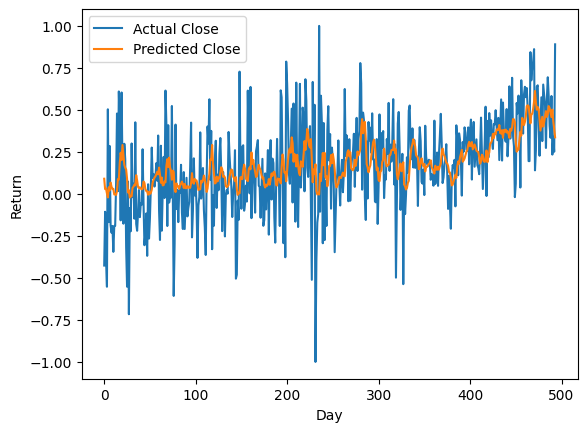

In [597]:
# No gradient for the prediction
with torch.no_grad():
    # Give the model the first 95% of the train data then give it to the cpu because numpy only use the cpu
    predicted = model(X_train.to(device)).to('cpu').numpy()


# Plot the y_train, real closing data
plt.plot(y_train, label='Actual Close')
# Plot the predicted closing value
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()
plt.show()

In [598]:
# Flatten to making sure it's one axis
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
# Inverse transform to transform the -1 1 to real dollar
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([-17.02569426, -19.71429063, -19.55473584, -20.84823753,
       -21.87967924, -19.22656989, -20.07589724, -18.02452822,
       -19.09423794, -19.7211322 , -19.63979308, -21.11595779,
       -21.06255996, -21.22382984, -20.19499567, -17.15077514,
       -17.26008074, -12.94765793, -10.29124499, -12.16923655,
        -8.26949587, -10.70349796, -13.42860305, -14.18136567,
       -14.63116889, -17.0257326 , -20.59719789, -19.98479956,
       -21.91745203, -21.51659472, -21.58742162, -19.40309257,
       -19.08700117, -18.56124531, -18.74604564, -16.10813299,
       -17.4675616 , -19.14375749, -19.5012844 , -19.23765164,
       -19.58219892, -19.78063317, -19.62026961, -17.75809087,
       -18.12533428, -19.65132185, -20.21997806, -20.26037237,
       -21.18264829, -20.39159445, -20.94801071, -20.73147848,
       -19.86439402, -18.02373814, -17.2487948 , -16.74212692,
       -16.40250188, -15.85583619, -15.23314118, -15.89816201,
       -14.13304797, -15.93054685, -18.06030989, -16.73

In [599]:
# Same as above for the truth
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

/var/folders/8t/zq98g53s2rs8x1qgc3h02m100000gn/T/ipykernel_22093/61638427.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([-3.95583105e+01, -2.55987724e+01, -3.80106186e+01, -4.50609167e+01,
        9.91164884e-01, -2.82895509e+01, -8.52412132e+00, -2.90853411e+01,
       -3.10264331e+01, -2.92806761e+01, -3.60099911e+01, -2.93064505e+01,
       -2.92381826e+01, -1.84655351e+01, -1.01729238e-01, -2.02644003e+01,
        5.62194228e+00, -3.26933386e+00, -2.78263137e+01,  5.35826598e+00,
       -1.40464991e+01, -2.86911670e+01, -7.95856030e+00, -1.19394161e+01,
       -3.48291642e+01, -4.50526365e+01, -1.77506647e+01, -5.21947620e+01,
       -2.46605212e+01, -3.06524230e+01, -7.87749780e+00, -2.18102959e+01,
       -1.83275341e+01, -2.73955575e+01, -2.38234401e+00, -2.87552974e+01,
       -3.05311093e+01, -2.59012286e+01, -1.99746034e+01, -2.69908409e+01,
       -2.33799241e+01, -2.37649133e+01, -9.38307502e+00, -2.33253730e+01,
       -3.42800376e+01, -3.11623159e+01, -2.60401164e+01, -3.70369395e+01,
       -1.84654885e+01, -3.25535784e+01, -2.72401073e+01, -1.91437607e+01,
       -8.93946704e+00, -

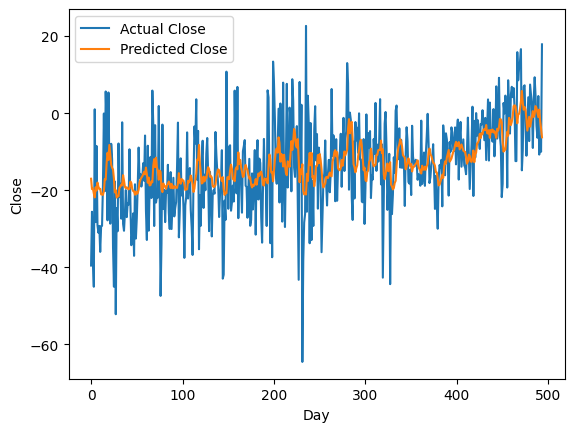

In [600]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [601]:
# The same as above but for the predictions .detach() do the same as .no_grad()
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([-2.15421483, -2.6680074 , -5.20457049, -1.46443967, -2.21116038,
       -3.75944871, -3.079443  , -2.4787416 ,  1.02406497,  0.33924211,
        1.63989355,  3.81993552,  2.61366488,  1.40029911, -1.28840381,
       -1.48007494, -0.21682236, -1.33440389, -1.50378515, -1.04574651,
       -0.79528067, -0.90216501,  0.43916907,  1.42936835,  2.00446622,
        2.31679482,  2.78869625])

In [602]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/var/folders/8t/zq98g53s2rs8x1qgc3h02m100000gn/T/ipykernel_22093/1312012603.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([ -3.38721045, -12.83495649,   9.61069629,  -5.39107882,
       -13.24614389,   9.60120753,   1.63832119,  11.30771593,
         2.37451746,   4.06205354,   8.33451914,   0.61501261,
        -4.73496264, -10.2057292 ,  -0.87963993,  10.68068588,
         0.66273449,  -1.94975817,  -1.98471532,  -4.83890108,
        -0.86108474,  13.26021738,   8.9400143 ,   4.47426752,
         2.0628178 ,   1.83501999,  -1.68101912])

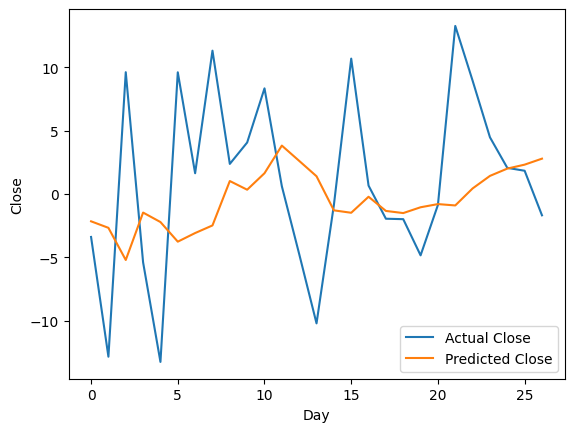

In [603]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [604]:
def log_predictions_to_tensorboard(y_actual, y_predicted, title, step):
    fig, ax = plt.subplots()
    ax.plot(y_actual, label='Actual Close')
    ax.plot(y_predicted, label='Predicted Close')
    ax.set_xlabel('Day')
    ax.set_ylabel('Close')
    ax.legend()
    writer.add_figure(title, fig, global_step=step)
    

In [605]:
log_predictions_to_tensorboard(new_y_train, train_predictions, "Train Predictions", epoch)
log_predictions_to_tensorboard(new_y_test, test_predictions, "Test Predictions", epoch)

In [606]:
loaded_model = LSTM(1, 4, 1)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
loaded_model.eval()

/var/folders/8t/zq98g53s2rs8x1qgc3h02m100000gn/T/ipykernel_22093/706240240.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [607]:
def predict_future_values(model, initial_sequence, n_future_steps, lookback):
    """
    Prédit les valeurs futures en utilisant le modèle LSTM.
    
    Arguments:
    - model: le modèle LSTM entraîné.
    - initial_sequence: la séquence initiale utilisée pour prédire les valeurs futures.
    - n_future_steps: le nombre de pas dans le futur à prédire.
    - lookback: la taille de la fenêtre glissante.
    
    Retourne:
    - Une liste des prédictions futures.
    """
    model.eval()
    predictions = []
    
    # Assurez-vous que la séquence initiale est un tenseur 3D [batch_size, lookback, features]
    input_seq = initial_sequence.reshape(1, lookback, 1).to(device)

    with torch.no_grad():
        for _ in range(n_future_steps):
            # Obtenir la prédiction pour l'étape suivante
            pred = model(input_seq)
            predictions.append(pred.item())
            
            # Mettre à jour la séquence en supprimant le plus ancien et en ajoutant la prédiction
            new_input = pred.reshape(1, 1, 1)  # Forme [batch_size, 1, features]
            input_seq = torch.cat((input_seq[:, 1:, :], new_input), dim=1)
    
    return predictions


In [608]:
initial_sequence = X_test[-1]

# Prédire les valeurs futures
future_predictions = predict_future_values(loaded_model, initial_sequence, 1, lookback)

In [609]:
dummies = np.zeros((len(future_predictions), lookback + 1))
dummies[:, 0] = future_predictions
dummies = scaler.inverse_transform(dummies)
future_predictions = dummies[:, 0]

In [610]:
last_date = data['Year-Month'].iloc[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=1, freq='MS')

future_df = pd.DataFrame({'Year-Month': future_dates, 'Predicted Return': future_predictions})
print(future_df)

  Year-Month  Predicted Return
0 2024-11-01          2.788696


In [611]:
def log_table_to_tensorboard(df, title, step):
    """
    Loggue un tableau Pandas sous forme de texte dans TensorBoard.
    
    Arguments :
    - df : DataFrame à logger
    - title : Titre pour la section dans TensorBoard
    - step : Étape actuelle pour le suivi
    """
    # Convertir le DataFrame en texte formaté
    table_text = df.to_string(index=False)
    
    # Ajout au logger TensorBoard
    writer.add_text(title, f"```\n{table_text}\n```", global_step=step)

print(future_df)
log_table_to_tensorboard(future_df, 'Future Predictions', epoch)

# Fermer TensorBoard
writer.close()

  Year-Month  Predicted Return
0 2024-11-01          2.788696
